# Tratamento dos dados

In [2]:
import pandas as pd

## Importando Bases de Dados

In [3]:
goals = pd.read_csv('goals.csv')
matches = pd.read_csv('matches.csv', dtype={"match_type": "category"})

## Informações Sobre os Dados - Matches

In [0]:
matches.info()

In [0]:
matches.sample(10)

In [0]:
matches.describe()

In [0]:
goals.head()

Número de gols por jogador

Identificar em cada Partida:
* Quem venceu e quem perdeu o jogo;
* Quantos gols foram marcados por cada jogador;
* A vitória foi fácil;

### Inserindo colunas ['goals_players_1', 'goals_players_2', 'winner', 'defeated', 'easy_win'] no dataframe matches

In [0]:
for index, row in matches.iterrows():
  goals_player_1 = goals.query("match_id == @row.match_id and player_id == @row.player_1")['goal_id'].count()
  goals_player_2 = goals.query("match_id == @row.match_id and player_id == @row.player_2")['goal_id'].count()
  winner = row.player_1 if goals_player_1 > goals_player_2 else row['player_2']
  defeated = row.player_2 if goals_player_1 > goals_player_2 else row['player_1']
  easy_win = abs(goals_player_1 - goals_player_2) > 4
  matches.at[index, 'goals_player_1'] = goals_player_1
  matches.at[index, 'goals_player_2'] = goals_player_2
  matches.at[index, 'winner'] = winner
  matches.at[index, 'defeated'] = defeated
  matches.at[index, 'easy_win'] = easy_win

In [0]:
matches.to_csv('matches_goals.csv')

# Importando base 'matches_with_goals.csv'


In [0]:
matches = pd.read_csv('matches_with_goals.csv')

In [0]:
matches.head()

,match_id,match_type,player_1,player_2,match_date,match_duration,goals_player_1,goals_player_2,winner,defeated,easy_win
0,M02109295,Ranked,DA1X9864,IA8T7256,2019-05-20,00:10:00,5.0,0.0,DA1X9864,IA8T7256,True
1,M02109296,Casual,SZ0S2637,CK8P4729,2020-11-18,00:10:00,5.0,0.0,SZ0S2637,CK8P4729,True
2,M02109297,Ranked,QX0H6977,PK9E7375,2020-02-28,00:10:00,2.0,0.0,QX0H6977,PK9E7375,False
3,M02109298,Casual,BK3W3327,QZ7C5416,2019-07-01,00:10:00,3.0,0.0,BK3W3327,QZ7C5416,False
4,M02109299,Casual,EG5I9716,GN4N5747,2020-12-11,00:10:00,6.0,0.0,EG5I9716,GN4N5747,True


## Identificando Todos os Usuários e criando novo DataFrame com as estatísticas de cada um

In [0]:
players = pd.DataFrame(pd.unique(matches[['player_1', 'player_2']].values.ravel('K')))

In [0]:
players.columns = ['player_id']
players.head()

,player_id
0,DA1X9864
1,SZ0S2637
2,QX0H6977
3,BK3W3327
4,EG5I9716


### Contando número de empates

In [0]:
matches.winner.isnull().sum()

0

### NENHUMA PARTIDA TERMINOU EMPATADA


Identificar em cada Jogador:
* Número de jogos;
* Número de vitórias;
* Número de derrotas;
* Percentual de aproveitamento;
* Número de goleadas aplicadas;
* Número de goleadas sofridas;


In [0]:
for index, row in players.iterrows():
  matches_count = matches.query("player_1 == @row.player_id or player_2 == @row.player_id")['match_id'].count()
  wins_count = matches.query("winner == @row.player_id")['match_id'].count()
  easy_wins_count = matches.query("winner == @row.player_id and easy_win == True")['match_id'].count()
  defeated_count = matches.query("defeated == @row.player_id")['match_id'].count()
  easy_defeated_count = matches.query("defeated == @row.player_id and easy_win == True")['match_id'].count()
  
  players.at[index, 'matches_count'] = matches_count
  players.at[index, 'wins_count'] = wins_count
  players.at[index, 'easy_wins_count'] = easy_wins_count
  players.at[index, 'defeated_count'] = defeated_count
  players.at[index, 'easy_defeated_count'] = easy_defeated_count

In [0]:
players['score'] = players['wins_count'] / players['matches_count']

In [0]:
players.head()

In [0]:
players.corr()

In [4]:
players.to_csv('players.csv', index=False)

NameError: name 'players' is not defined

In [0]:
players = pd.read_csv('players.csv')

In [0]:
players.describe()

,matches_count,wins_count,easy_wins_count,defeated_count,easy_defeated_count,score
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,19.998900,10.000000,6.040100,10.000000,6.040100,0.500399
std,4.459943,3.119771,2.432382,3.185093,2.450733,0.114493
min,5.000000,1.000000,0.000000,0.000000,0.000000,0.062500
25%,17.000000,8.000000,4.000000,8.000000,4.000000,0.424242
50%,20.000000,10.000000,6.000000,10.000000,6.000000,0.500000
75%,23.000000,12.000000,8.000000,12.000000,8.000000,0.576923
max,37.000000,24.000000,20.000000,25.000000,17.000000,1.000000


In [0]:
players.head()

,player_id,matches_count,wins_count,easy_wins_count,defeated_count,easy_defeated_count,score
0,DA1X9864,24.0,9.0,4.0,15.0,9.0,0.375000
1,SZ0S2637,22.0,14.0,10.0,8.0,6.0,0.636364
2,QX0H6977,20.0,12.0,7.0,8.0,7.0,0.600000
3,BK3W3327,14.0,11.0,6.0,3.0,3.0,0.785714
4,EG5I9716,22.0,12.0,9.0,10.0,7.0,0.545455


# Clustering

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

## Definindo as variáveis mais importantes

### Levando em conta que queremos agrupar os jogadores por níveis, as variáveis mais relevantes e que levaremos em consideração no agrupamento são:
* Número de Partidas;
* Número de goleadas aplicadas;
* Número de goleadas sofridas;
* Porcentagem de vitórias;

# 1.KMeans

In [0]:
from sklearn.cluster import KMeans

In [0]:
X = players.iloc[:,[1,3,5,6]].values
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [0]:
pd.DataFrame(X)

,0,1,2,3
0,0.897164,-0.838767,1.207821,-1.095307
1,0.448705,1.628074,-0.016363,1.187596
2,0.000247,0.394653,0.391698,0.869975
3,-1.345129,-0.016487,-1.240548,2.492112
4,0.448705,1.216934,0.391698,0.393543
...,...,...,...,...
9995,-1.569359,-1.661047,-1.240548,-2.355103
9996,-1.793588,-1.661047,0.391698,-2.187130
9997,-1.120900,-1.249907,-0.832486,-1.459248
9998,-1.793588,-2.072187,-0.016363,-0.003484


#### Definindo o número de clusters


In [0]:
wcss = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

Text(0, 0.5, 'WCSS')

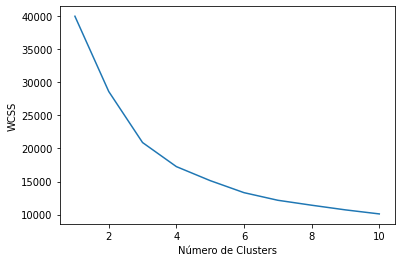

In [0]:
plt.plot(range(1,11), wcss)
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')

### Treinando o Modelo

In [0]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans_predict = kmeans.fit_predict(X)

In [0]:
players_predicted = np.column_stack((players, kmeans_predict))
# players_predicted = players_predicted[players_predicted[:, 7].argsort()]
predicted_df = pd.DataFrame(players_predicted)

In [0]:
# X_inverse = scaler.inverse_transform(X)
# pd.DataFrame(X_inverse)

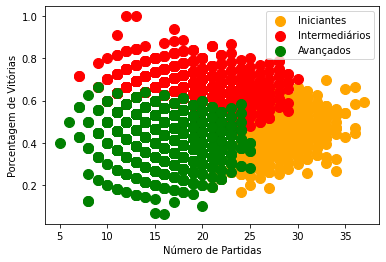

In [0]:
def kmeans_plot():
  plt.scatter(X_inverse[kmeans_predict == 0, 0], X_inverse[kmeans_predict == 0, 3], s=100, c='orange', label='Iniciantes')
  plt.scatter(X_inverse[kmeans_predict == 1, 0], X_inverse[kmeans_predict == 1, 3], s=100, c='red', label='Intermediários')
  plt.scatter(X_inverse[kmeans_predict == 2, 0], X_inverse[kmeans_predict == 2, 3], s=100, c='green', label='Avançados')
  plt.xlabel('Número de Partidas')
  plt.ylabel('Porcentagem de Vitórias')
  plt.legend()

kmeans_plot()

### De acordo com o gráfico de Número de partidas x Porcentagem de Vitórias, os grupos mostram: 
* Iniciantes: jogadores com poucas partidas e com um aproveitamento de vitórias baixo/médio;
* Intermediários: jogadores com mais partidas e aproveitamento de vitórias baixo/médio;
* Avançados: jogadores com maior porcentagem de vitórias e número de jogos baixos/médios.



# 2. Agrupamento Hierárquico

In [0]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

Text(0.5, 1.0, 'Dendograma')

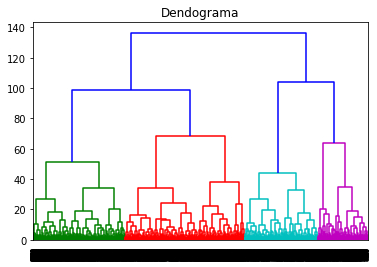

In [0]:
dendograma = dendrogram(linkage(X, method='ward'))
plt.title('Dendograma')

In [0]:
hc = AgglomerativeClustering(n_clusters=4)
agg_predict = hc.fit_predict(X)

In [0]:
X_inverse = scaler.inverse_transform(X)

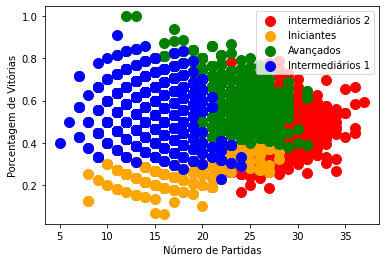

In [0]:
def agg_plot():
  plt.scatter(X_inverse[agg_predict == 1, 0], X_inverse[agg_predict == 1, 3], s=100, c='red', label='intermediários 2')
  plt.scatter(X_inverse[agg_predict == 0, 0], X_inverse[agg_predict == 0, 3], s=100, c='orange', label='Iniciantes')
  plt.scatter(X_inverse[agg_predict == 2, 0], X_inverse[agg_predict == 2, 3], s=100, c='green', label='Avançados')
  plt.scatter(X_inverse[agg_predict == 3, 0], X_inverse[agg_predict == 3, 3], s=100, c='blue', label='Intermediários 1')
  plt.xlabel('Número de Partidas')
  plt.ylabel('Porcentagem de Vitórias')
  plt.legend()

agg_plot()

# 3. DBSCAN

In [0]:
from sklearn.cluster import DBSCAN

### Treinando o modelo

In [0]:
dbscan = DBSCAN(eps=1, min_samples=2)
dbscan_predict = dbscan.fit_predict(X)

#### Verificando quantidade de clusters encontrado para ajustar o modelo

In [0]:
predict_unique, count = np.unique(dbscan_predict, return_counts=True)
print('Unicos: {} - Quantidade: {}'.format(predict_unique, count))

Unicos: [-1  0] - Quantidade: [   7 9993]


In [0]:
X_inverse = scaler.inverse_transform(X)

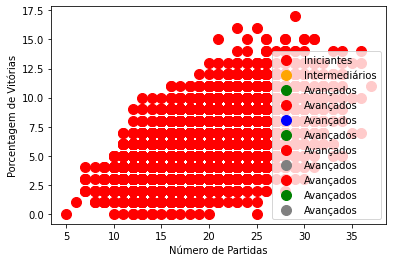

In [0]:
def dbscan_plot():
  plt.scatter(X_inverse[dbscan_predict == 0, 0], X_inverse[dbscan_predict == 0, 1], s=100, c='red', label='Iniciantes')
  plt.scatter(X_inverse[dbscan_predict == 1, 0], X_inverse[dbscan_predict == 1, 1], s=100, c='orange', label='Intermediários')
  plt.xlabel('Número de Partidas')
  plt.ylabel('Porcentagem de Vitórias')
  plt.legend()

dbscan_plot()

## Conclusão

### O algoritmo K-means obteve o melhor conjunto de dados para esse data-set. Dividindo os jogadores em um grupo com maior percentual de vitórias e outros dois grupos com percentual de vitória parecidos, porem com menor número de jogos.